In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = sns.load_dataset('titanic')

df = df.drop(columns=['deck', 'embark_town', 'alive'])

df.dropna(subset=['embarked', 'age'], inplace=True)

df['age'] = df['age'].fillna(df['age'].median())

label_cols = ['sex', 'embarked', 'class', 'who', 'adult_male', 'alone']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

X = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'who', 'adult_male', 'alone']]
y = df['survived']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    print(f"\nModel: {name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    return f1_score(y_test, y_pred)


Model: Logistic Regression
[[68 12]
 [18 45]]
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        80
           1       0.79      0.71      0.75        63

    accuracy                           0.79       143
   macro avg       0.79      0.78      0.78       143
weighted avg       0.79      0.79      0.79       143


Model: Random Forest
[[67 13]
 [20 43]]
              precision    recall  f1-score   support

           0       0.77      0.84      0.80        80
           1       0.77      0.68      0.72        63

    accuracy                           0.77       143
   macro avg       0.77      0.76      0.76       143
weighted avg       0.77      0.77      0.77       143


Model: SVM
[[70 10]
 [16 47]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        80
           1       0.82      0.75      0.78        63

    accuracy                           0.82       143
   macro 

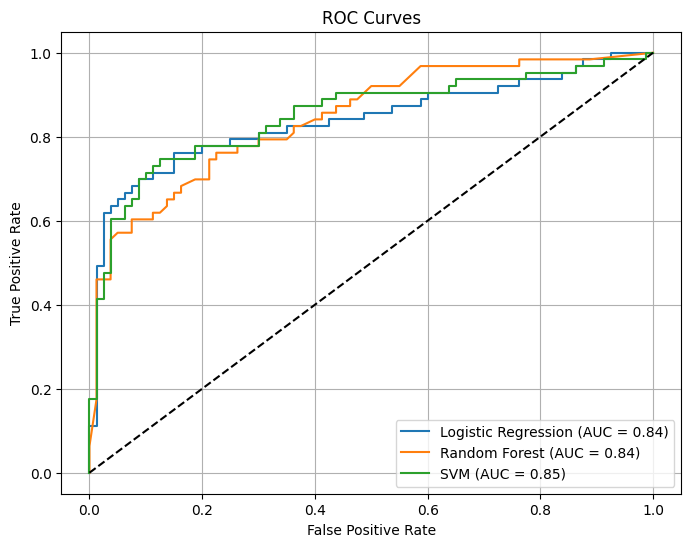

In [ ]:
from sklearn.metrics import roc_curve, auc  # <-- ADD THIS if missing

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True)
}

f1_scores = {}

plt.figure(figsize=(8, 6))
for name, model in models.items():
    model.fit(X_train, y_train)
    score = evaluate_model(name, model)
    f1_scores[name] = score

# Plot reference line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()


Best SVM Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

Model: SVM (Tuned)
[[69 11]
 [17 46]]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        80
           1       0.81      0.73      0.77        63

    accuracy                           0.80       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.80      0.80      0.80       143



0.7666666666666667

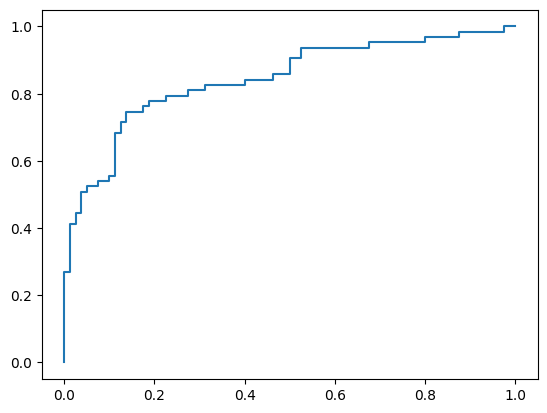

In [ ]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='f1')
grid_svm.fit(X_train, y_train)

print("\nBest SVM Parameters:", grid_svm.best_params_)
best_svm = grid_svm.best_estimator_
evaluate_model("SVM (Tuned)", best_svm)


Best RF Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 8}

Model: Random Forest (Tuned)
[[72  8]
 [21 42]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        80
           1       0.84      0.67      0.74        63

    accuracy                           0.80       143
   macro avg       0.81      0.78      0.79       143
weighted avg       0.80      0.80      0.79       143



0.7433628318584071

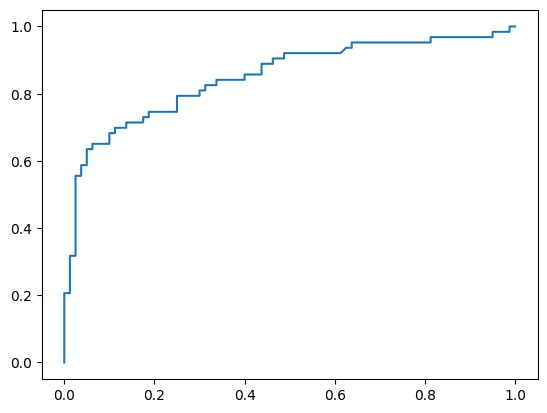

In [ ]:
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                               param_distributions=param_dist_rf,
                               n_iter=10, cv=5, scoring='f1', random_state=42)
random_rf.fit(X_train, y_train)

print("\nBest RF Parameters:", random_rf.best_params_)
best_rf = random_rf.best_estimator_
evaluate_model("Random Forest (Tuned)", best_rf)

In [ ]:
print("\nCross-validation scores (F1):")
for name, model in [("Logistic Regression", LogisticRegression()),
                    ("Random Forest", best_rf),
                    ("SVM", best_svm)]:
    scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    print(f"{name}: Mean = {scores.mean():.3f}, Std = {scores.std():.3f}")


Cross-validation scores (F1):
Logistic Regression: Mean = 0.762, Std = 0.051
Random Forest: Mean = 0.740, Std = 0.062
SVM: Mean = 0.764, Std = 0.053


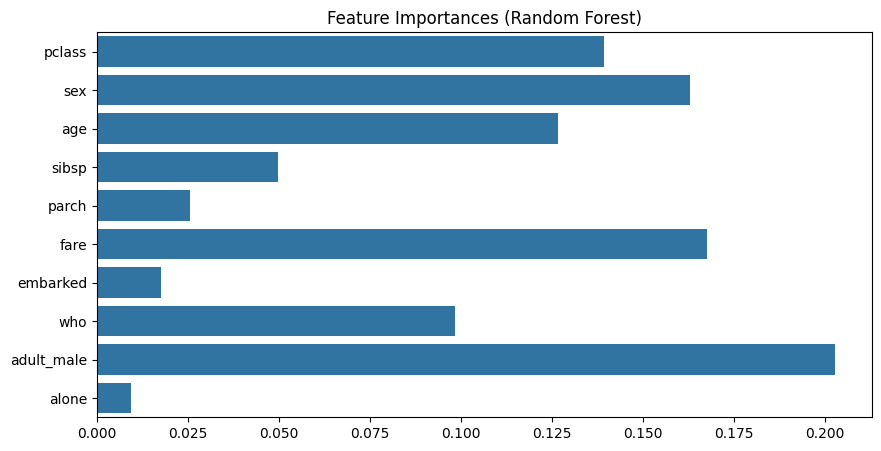

In [ ]:
importances = best_rf.feature_importances_
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'who', 'adult_male', 'alone']

plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances (Random Forest)")
plt.show()
